In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

sns.set(style='white', context='notebook', palette='deep')

# Data overview

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [7]:
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [8]:
dataset = dataset.fillna(np.nan)

print(dataset.isnull().sum())
print("-"*20)
print(train.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64
--------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


There's a few things to note here: Null values in the "Survived" features are from the test set so there's nothing to worry about that. Null values in the "Cabin" features might mean those passengers don't have any. Null values in "Age" features might need some work to deal with. 

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Christy, Miss. Julie Rachel",male,347082,G6,S
freq,1,577,7,4,644


# Feature Analysis

There are four features (SibSp, Parch, Age, Fare) which the data may have some outliers.

In [11]:
# detecting outliers using interquartil range

def iqr_outliers(data, columns):
  outlier_idxs = []
  for col in columns:
    Q1 = np.percentile(data[col], 25, interpolation="midpoint")
    Q3 = np.percentile(data[col], 75, interpolation="midpoint")
    IQR = Q3 - Q1

    outliers = data[(data[col] < (Q1-1.5*IQR)) | (data[col] > (Q3+1.5*IQR))]

    outlier_idxs.extend(outliers.index)

  idx_occurrence = Counter(outlier_idxs)
  final_idxs = [v for v, w in idx_occurrence.items() if w > 2]
  return final_idxs

In [12]:
idxs_with_outliers = iqr_outliers(train, ["SibSp", "Parch", "Age", "Fare"])
train.loc[idxs_with_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Looks like there are some outliers within the Fare and SibSp features. Playing more with the data may show how important it is to remove the outliers.

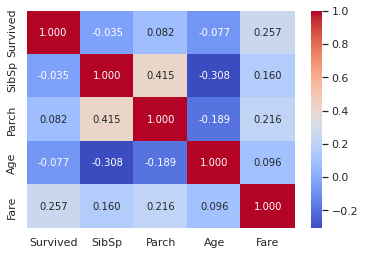

In [13]:
plot = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),
                   annot=True,
                   fmt='.3f',
                   cmap = 'coolwarm')

Fare feature seems to be the only one that has a considerably high correlation with survival. But that doesn't necessarily mean the other features are not as important as fare.

## Numerical Features

### SibSp

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


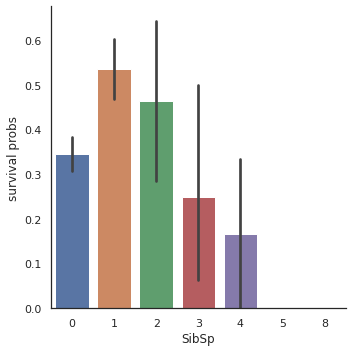

In [14]:
g = sns.catplot(x='SibSp', y='Survived', data=dataset,
                   kind='bar', height=5)
g = g.set_ylabels("survival probs")

train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Passengers with a lot of siblings/spouses seems to have less chance to survive while single passengers or with two other person have better chance to survive.

### Parch

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


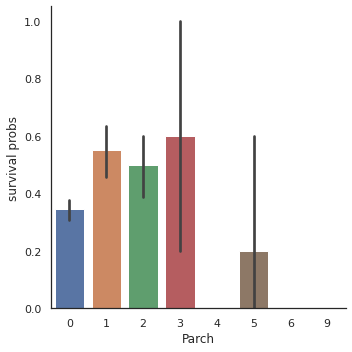

In [15]:
g = sns.catplot(x='Parch', y='Survived', data=dataset,
                   kind='bar', height=5)
g = g.set_ylabels("survival probs")

train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Small sized family (1 & 2) seems to have higher chance to survive than single person (0 Parch) and large families.

There's a very noticeable standard deviation with passengers with 3 Parch, need to further analyze Parch feature.

### Age

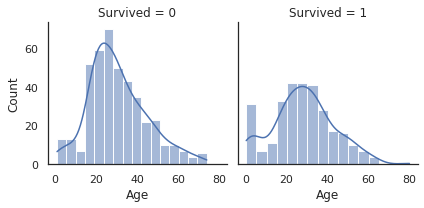

In [16]:
g = sns.FacetGrid(train, col="Survived")
g.map(sns.histplot, "Age", kde=True)

Looks like younger passenger have more chance to survive compared to older passengers, especially passengers in the range between 60-80.

### Fare

since there's only one Nan value in Fare feature, I decided to just replace it with the mean of all Fare.

In [17]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
dataset["Fare"].isnull().sum()

0

Skewness:  4.3695095504693855


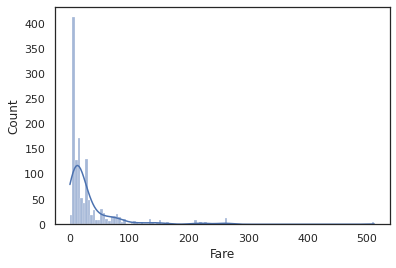

In [18]:
g = sns.histplot(dataset["Fare"], kde=True)
print("Skewness: ", dataset["Fare"].skew())

since the Fare feature is very skewed, it might be better to transform them with the log function.

In [19]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [20]:
train["Fare_log"] = train["Fare"].map(lambda i: np.log(i) if i>0 else 0)

Skewness:  0.5694341694913937


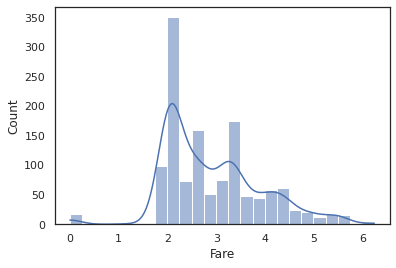

In [21]:
g = sns.histplot(dataset["Fare"], kde=True)
print("Skewness: ", dataset["Fare"].skew())

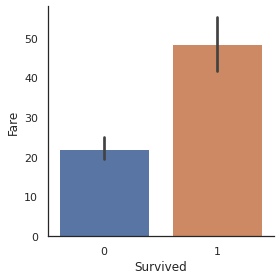

In [22]:
g = sns.catplot(x="Survived", y="Fare", data=train, kind="bar", height=4)

This plot basically just confirms that Fare has quite a correlation with survival of the passengers.

## Categorical Features

### Sex

,Sex,Survived
0,female,0.742038
1,male,0.188908


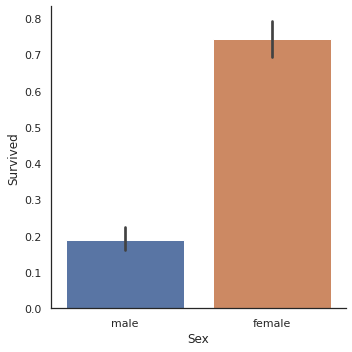

In [23]:
g = sns.catplot(x="Sex", y="Survived", data=train,
                kind="bar")
train[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

Yep, ofcourse female have bigger chance to survive than male.

### Pclass

In [24]:
train[["Pclass", "Survived", "Fare"]].groupby(["Pclass"], as_index=False).mean()

,Pclass,Survived,Fare
0,1,0.629630,84.154687
1,2,0.472826,20.662183
2,3,0.242363,13.675550


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


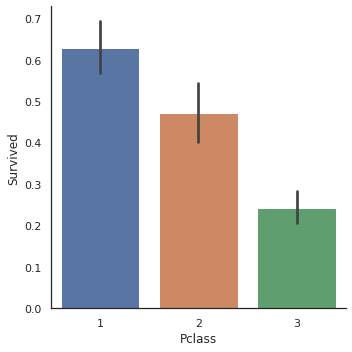

In [25]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar")
train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

As expected, passengers in the first class have bigger chance to survive. It should be interesting to see how the chances are distributed across Age and Sex.

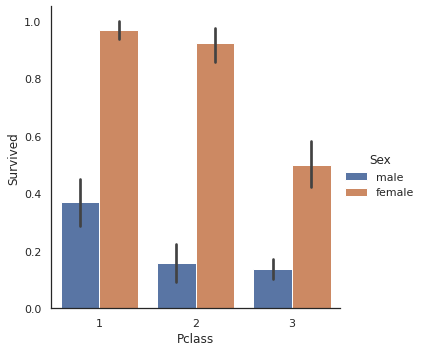

In [26]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar")

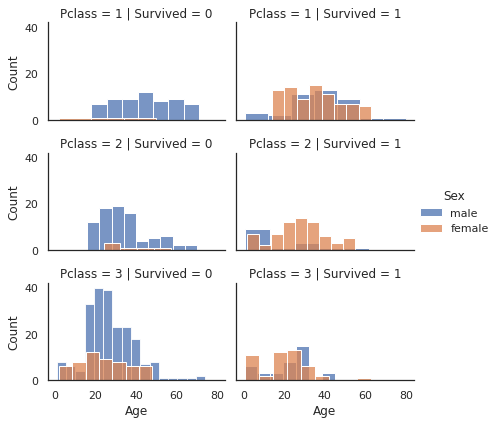

In [27]:
g = sns.FacetGrid(train, col="Survived", row="Pclass", hue="Sex",
                  height=2, aspect=1.5)
g.map(sns.histplot, "Age")
g.add_legend()

There are some interesting points to take from the two plots. First of, both male and female passangers chance to survive across Pclass features have the same trend as the Pclass itself, with female having way bigger chance to survive. The Age feature is a bit more interesting. In the first class we can see that the survival count distributed quite evenly throughout the whole age range persumably because the first passenger have higher priority to be saved which is exactly what the survival probability plot shows. On the second and third class, we can see more clearly how the priority of rescue is given more to women and children.

### Embarked

Since there's only 2 missing values from embarked feature, and S being the most frequent value of embarked by some margin (644 out of 889), I decided to replace the missing value with S.

In [28]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")
train["Embarked"] = train["Embarked"].fillna("S")
dataset["Embarked"].isnull().sum()

0

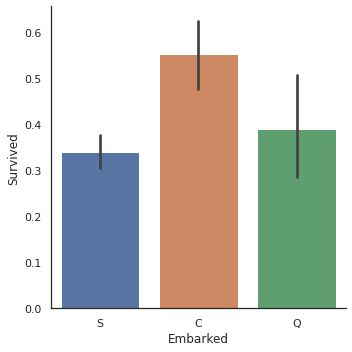

In [29]:
g = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar")

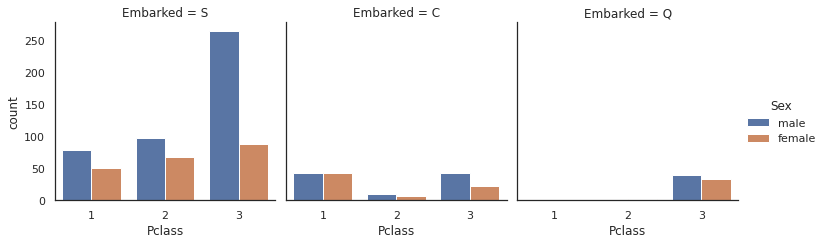

In [30]:
g = sns.catplot(x="Pclass", col="Embarked", data=train, kind="count", hue="Sex", height=3.5)

Apparently more passengers who embarked from C are taking the first class, which explains why passengers from C have bigger chance to survive.

# Data Wrangling and Feature Engineering

## Adding Age Missing Values

In [31]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1}).astype(int)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,S


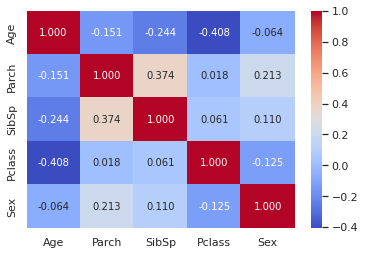

In [32]:
g = sns.heatmap(dataset[["Age", "Parch", "SibSp", "Pclass", "Sex"]].corr(),
                   annot=True,
                   fmt='.3f',
                   cmap = 'coolwarm')

Looks like Age feature has a negative correlation with Pclass, SibSp, and Parch features but not quite enough correlation with Sex feature. Let's explore it even further with boxplot

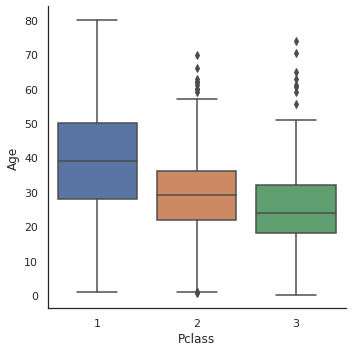

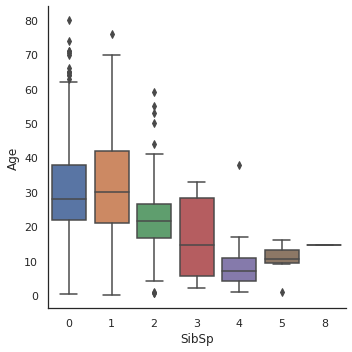

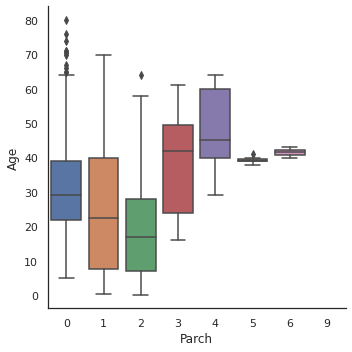

In [33]:
g = sns.catplot(y="Age",x="Pclass",data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")

with that I decided to go with the median value of Age of similar rows according to Pclass, SibSp, and Parch.

In [34]:
age_null_idxs = list(dataset["Age"][dataset["Age"].isnull()].index)

for idx in age_null_idxs:
  age_pred = dataset["Age"][((dataset["Pclass"] == dataset.iloc[idx]["Pclass"]) &\
                            (dataset["SibSp"] == dataset.iloc[idx]["SibSp"]) &\
                            (dataset["Parch"] == dataset.iloc[idx]["Parch"]))].median()
  if not np.isnan(age_pred):
    dataset["Age"].iloc[idx] = age_pred
  else:
    dataset["Age"].iloc[idx] = dataset["Age"].median()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [35]:
dataset["Age"].isnull().sum()

0

## PassengerId

Basically just dropping passengerid column

In [36]:
dataset = dataset.drop("PassengerId", axis=1)
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,S


## Name

Name feature contains passengers title and that might be important to add to the model

In [37]:
dataset["Title"] = pd.Series([i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]])
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

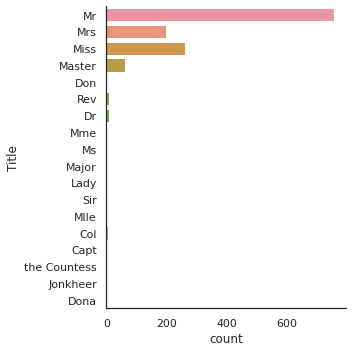

In [38]:
g = sns.catplot(data=dataset, y="Title", kind="count", height=5, aspect=1)

In [39]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master": 0, "Mrs": 1, "Miss": 1, "Mlle": 1, "Ms": 1, "Mme": 1, "Mr": 2, "Rare":3})
dataset["Title"].head()

0    2
1    1
2    1
3    1
4    2
Name: Title, dtype: int64

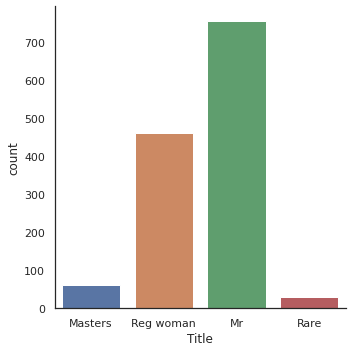

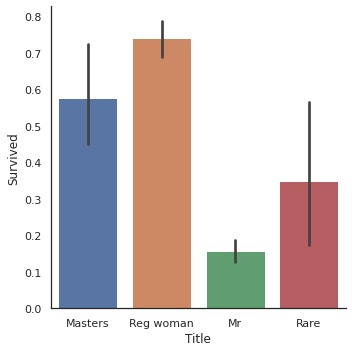

In [40]:
g = sns.catplot(data=dataset, x="Title", kind="count")
g.set_xticklabels(["Masters", "Reg woman", "Mr", "Rare"])
g = sns.catplot(data=dataset, x="Title", y="Survived", kind="bar")
g.set_xticklabels(["Masters", "Reg woman", "Mr", "Rare"])

Passengers titled Mr, just like earlier observations, have less chance to survive compared to others. Rare title category has a noticeable standard deviation due to it's wide range of title variety and it's priority of being saved.

## Age

Since age feature doesn't have good enough correlation with survival, I decided to group it into category of ranges.

In [41]:
group_by = 5
bin = [i*5 for i in range(int(np.ceil(train["Age"].max()/group_by))+1)]
train['AgeBand'] = pd.cut(train['Age'], bins=bin)

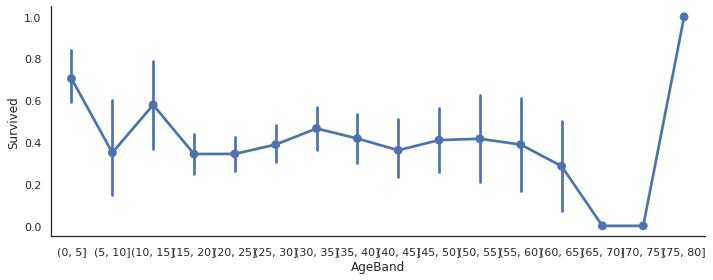

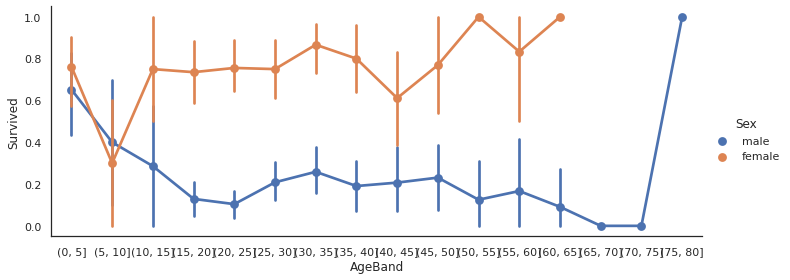

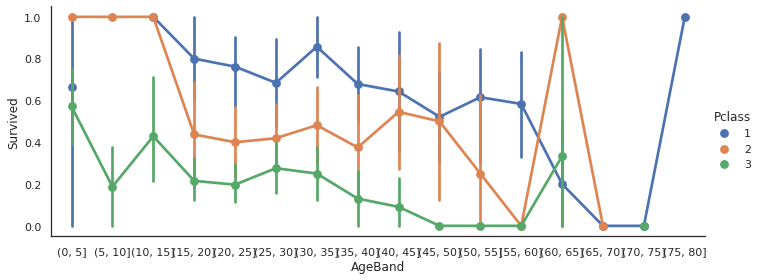

In [42]:
g = sns.catplot(data=train, x="AgeBand", y="Survived", kind="point", height=4, aspect=2.5)
g = sns.catplot(data=train, x="AgeBand", y="Survived", kind="point", hue="Sex", height=4, aspect=2.5)
g = sns.catplot(data=train, x="AgeBand", y="Survived", kind="point", hue="Pclass", height=4, aspect=2.5)

I think it's safe to say that Age features can be grouped into 3 categories:
>- youth: (0, 15]
>- elderly: (15, 60]
>- very old: (60, 80]

In [43]:
dataset.loc[dataset["Age"] <= 15, "Age"] = 0
dataset.loc[(dataset["Age"] > 15) & (dataset["Age"] <= 60), "Age"] = 1
dataset.loc[(dataset["Age"] >60) & (dataset["Age"] <= 80), "Age"] = 2
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0.0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,1.981001,NaN,S,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,PC 17599,4.266662,C85,C,1
2,1.0,3,"Heikkinen, Miss. Laina",1,1.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,113803,3.972177,C123,S,1
4,0.0,3,"Allen, Mr. William Henry",0,1.0,0,0,373450,2.085672,NaN,S,2


## Ticket

The ticket feature will be dropped since it may not have enough correlation with survival and it also has quite high ratio of duplicates

In [44]:
dataset = dataset.drop("Ticket", axis=1)
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0.0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,1.981001,NaN,S,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,4.266662,C85,C,1
2,1.0,3,"Heikkinen, Miss. Laina",1,1.0,0,0,2.070022,NaN,S,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,3.972177,C123,S,1
4,0.0,3,"Allen, Mr. William Henry",0,1.0,0,0,2.085672,NaN,S,2


## Fare

Fare has enough correlation with survived feature, therefore I decided to keep it as it is (with log function transformation). With that said, it considerably necessary to remove the outliers that we found at the beginning.

In [45]:
dataset = dataset.drop([27, 88, 341], axis = 0).reset_index(drop=True)

## SibSp and Parch (Family)

To make the features become more compact and possibly yield to a better model, SibSp and Parch features can be combined together into Family feature.

In [46]:
dataset["Family"] = dataset["SibSp"] + dataset["Parch"] + 1

In [47]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family
0,0.0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,1.981001,NaN,S,2,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,4.266662,C85,C,1,2
2,1.0,3,"Heikkinen, Miss. Laina",1,1.0,0,0,2.070022,NaN,S,1,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,3.972177,C123,S,1,2
4,0.0,3,"Allen, Mr. William Henry",0,1.0,0,0,2.085672,NaN,S,2,1


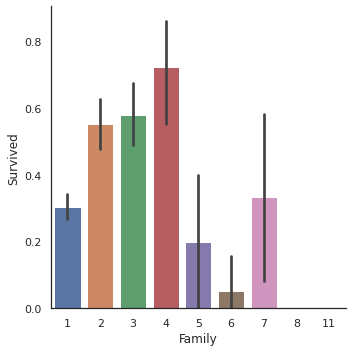

In [48]:
g = sns.catplot(data=dataset, x="Family", y="Survived", kind="bar")

From this observation I decided to seperate Family feature into 4 categories: single(1), small(2-4), medium(5-7), and big(>8)

In [49]:
dataset['Single'] = dataset['Family'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Family'].map(lambda s: 1 if 2 <= s <= 4 else 0)
dataset['MedF'] = dataset['Family'].map(lambda s: 1 if 5 <= s <= 7 else 0)
dataset['BigF'] = dataset['Family'].map(lambda s: 1 if s >= 8 else 0)

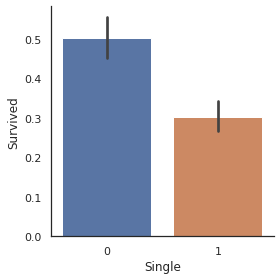

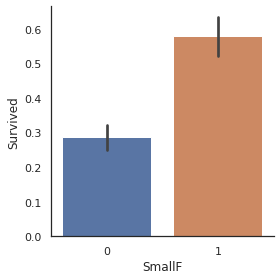

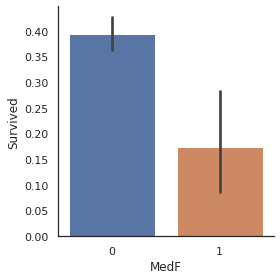

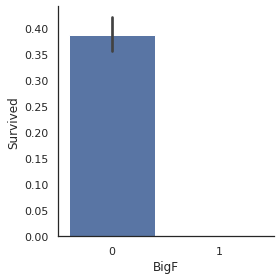

In [50]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar", height=4)
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar", height=4)
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar", height=4)
g = sns.catplot(x="BigF",y="Survived",data=dataset,kind="bar", height=4)

Small family having the biggest chance to survive probably because they can communicate and help each other quite easily since there's not too many family member to take care of.

In [51]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family,Single,SmallF,MedF,BigF
0,0.0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,1.981001,NaN,S,2,2,0,1,0,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,4.266662,C85,C,1,2,0,1,0,0
2,1.0,3,"Heikkinen, Miss. Laina",1,1.0,0,0,2.070022,NaN,S,1,1,1,0,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,3.972177,C123,S,1,2,0,1,0,0
4,0.0,3,"Allen, Mr. William Henry",0,1.0,0,0,2.085672,NaN,S,2,1,1,0,0,0


## Cabin

By assuming the NaN value in Cabin feature as passengers without cabin, we can categorize the passengers by their cabin type (or no cabin).

In [52]:
dataset["Cabin"] = [i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]]

T       1
G       5
F      21
A      22
E      41
D      46
B      65
C      91
X    1014
Name: Cabin, dtype: int64

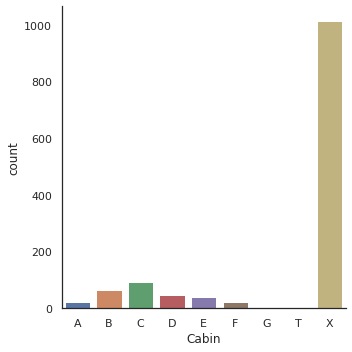

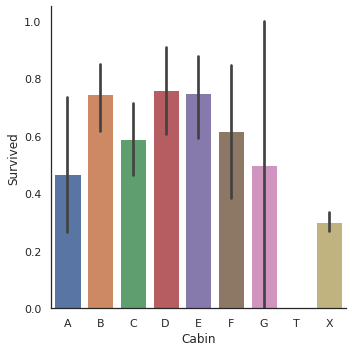

In [53]:
g = sns.catplot(data=dataset, x="Cabin", kind="count", 
                order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])
g = sns.catplot(data=dataset, x="Cabin", y="Survived", kind="bar",
                order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])
dataset['Cabin'].value_counts(ascending=True)

In general, passengers with cabin have bigger chance to survive compared to passengers without one. Since the number of passangers that have a cabin is relatively low, I decided to categorize them by having a cabin or not.

In [54]:
dataset["Cabin"] = dataset["Cabin"].map(lambda i: 0 if i == "X" else 1)

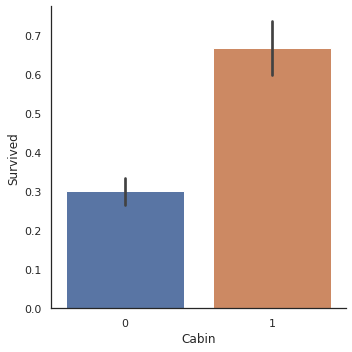

In [55]:
g = sns.catplot(data=dataset, x="Cabin", y="Survived", kind="bar")

## Finalizing Dataset

fistly let's check how the dataset looks like

In [56]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family,Single,SmallF,MedF,BigF
0,0.0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,1.981001,0,S,2,2,0,1,0,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,4.266662,1,C,1,2,0,1,0,0
2,1.0,3,"Heikkinen, Miss. Laina",1,1.0,0,0,2.070022,0,S,1,1,1,0,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,3.972177,1,S,1,2,0,1,0,0
4,0.0,3,"Allen, Mr. William Henry",0,1.0,0,0,2.085672,0,S,2,1,1,0,0,0


There's a couple things left to do:
>- get dummies for Age feature
>- get dummies for Pclass feature
>- drop Name feature
>- drop SibSp and Parch features
>- drop Family feature
>- get dummies for Embarked feature
>- get dummies for Title feature

In [57]:
dataset["Age"] = dataset["Age"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Age"], prefix="Age")

In [58]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [59]:
dataset = dataset.drop(["Name", "SibSp", "Parch", "Family"], axis=1)

In [60]:
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [61]:
dataset["Title"] = dataset["Title"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Title"], prefix="T")

In [62]:
dataset.head()

,Survived,Sex,Fare,Cabin,Single,SmallF,MedF,BigF,Age_0.0,Age_1.0,Age_2.0,Pc_1,Pc_2,Pc_3,Em_C,Em_Q,Em_S,T_0,T_1,T_2,T_3
0,0.0,0,1.981001,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,1.0,1,4.266662,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
2,1.0,1,2.070022,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
3,1.0,1,3.972177,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0
4,0.0,0,2.085672,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [63]:
train_len = len(train) - 3 # dropped 3 columns from trainset
train = dataset[:train_len]
X_test = dataset[train_len:]
X_test.drop(labels=["Survived"],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [105]:
print(train.isnull().sum())
print("-"*20)
print(X_test.isnull().sum())

Survived    0
Sex         0
Fare        0
Cabin       0
Single      0
SmallF      0
MedF        0
BigF        0
Age_0.0     0
Age_1.0     0
Age_2.0     0
Pc_1        0
Pc_2        0
Pc_3        0
Em_C        0
Em_Q        0
Em_S        0
T_0         0
T_1         0
T_2         0
T_3         0
dtype: int64
--------------------
Survived    418
Sex           0
Fare          0
Cabin         0
Single        0
SmallF        0
MedF          0
BigF          0
Age_0.0       0
Age_1.0       0
Age_2.0       0
Pc_1          0
Pc_2          0
Pc_3          0
Em_C          0
Em_Q          0
Em_S          0
T_0           0
T_1           0
T_2           0
T_3           0
dtype: int64


In [65]:
train["Survived"] = train["Survived"].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  888 non-null    int64  
 1   Sex       888 non-null    int64  
 2   Fare      888 non-null    float64
 3   Cabin     888 non-null    int64  
 4   Single    888 non-null    int64  
 5   SmallF    888 non-null    int64  
 6   MedF      888 non-null    int64  
 7   BigF      888 non-null    int64  
 8   Age_0.0   888 non-null    uint8  
 9   Age_1.0   888 non-null    uint8  
 10  Age_2.0   888 non-null    uint8  
 11  Pc_1      888 non-null    uint8  
 12  Pc_2      888 non-null    uint8  
 13  Pc_3      888 non-null    uint8  
 14  Em_C      888 non-null    uint8  
 15  Em_Q      888 non-null    uint8  
 16  Em_S      888 non-null    uint8  
 17  T_0       888 non-null    uint8  
 18  T_1       888 non-null    uint8  
 19  T_2       888 non-null    uint8  
 20  T_3       888 non-null    uint8 

#Model

In [67]:
# separate target and features
Y_train = train["Survived"]
X_train = train.drop(["Survived"], axis=1)
X_train.head()

,Sex,Fare,Cabin,Single,SmallF,MedF,BigF,Age_0.0,Age_1.0,Age_2.0,Pc_1,Pc_2,Pc_3,Em_C,Em_Q,Em_S,T_0,T_1,T_2,T_3
0,0,1.981001,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,1,4.266662,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
2,1,2.070022,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
3,1,3.972177,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0
4,0,2.085672,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


For the modelling part I want to try out ensemble modelling. It's basically combining multiple models for final prediction, usually by voting for classification problem. In order to do that, here are the steps we're going to go through:
>1. Find relatively good binary classification models
>2. Find the best hyperparameter for each of the selected models
>3. Combine models

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import time

In [69]:
kfold = StratifiedKFold(n_splits=10)

In [161]:
random_state = 7
models = []
models.append(LogisticRegression(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(KNeighborsClassifier())
models.append(MLPClassifier(random_state=random_state))
models.append(XGBClassifier(random_state=random_state))

scores = []
for model in models:
  scores.append(cross_val_score(model, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=-1))
  print("a model done")

scores_mean = []
scores_std = []
for score in scores:
    scores_mean.append(score.mean())
    scores_std.append(score.std())

scores_df = pd.DataFrame({
    "Mean_acc": scores_mean,
    "Std_acc": scores_std,
    "Models": ["LogReg", "Random forest", "Extra trees", "AdaBoost", "GradBoost", "SVC", "Decision tree", "KNeighbors", "MLP", "XGB"]
})
scores_df

a model done
a model done
a model done
a model done
a model done
a model done
a model done
a model done
a model done
a model done


,Mean_acc,Std_acc,Models
0,0.828894,0.038940,LogReg
1,0.819867,0.039054,Random forest
2,0.813126,0.043055,Extra trees
3,0.822102,0.045926,AdaBoost
4,0.835610,0.047374,GradBoost
5,0.831141,0.038371,SVC
6,0.824349,0.042042,Decision tree
7,0.823276,0.051841,KNeighbors
8,0.819918,0.036907,MLP
9,0.830005,0.051212,XGB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


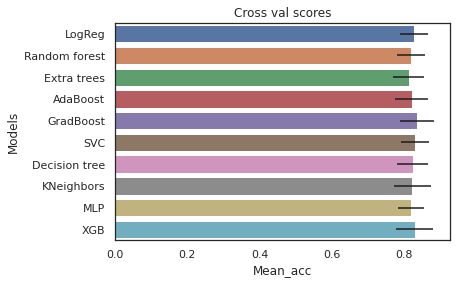

In [162]:
g = sns.barplot("Mean_acc","Models",data = scores_df,orient = "h",**{'xerr':scores_std})
g = g.set_title("Cross val scores")

I decided to do grid search for every single model except for Logistic regression and decission tree

In [164]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators" :[100,300],
                 "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
gsExtC.fit(X_train,Y_train)
end = time.time()
print("Fitting took", end-start, "s")

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting took 129.52155661582947 s


0.8424029622063329

In [166]:
KNC = KNeighborsClassifier()

kn_param_grid = {"leaf_size": [25, 30, 35, 40]}

KNCgs = GridSearchCV(KNC,param_grid = kn_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
KNCgs.fit(X_train,Y_train)
end = time.time()
print("Fitting took ", end-start, "s")

KNC_best = KNCgs.best_estimator_

KNCgs.best_score_

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting took  0.5253665447235107 s


0.823276302349336

In [96]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(), random_state=random_state)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

AdaBoostgs = GridSearchCV(AdaBoost,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
AdaBoostgs.fit(X_train,Y_train)
end = time.time()
print("Fitting took ", end-start, "s")

AdaBoost_best = AdaBoostgs.best_estimator_

AdaBoostgs.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
Fitting took  12.210699319839478 s


0.8310903983656793

In [97]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 5, 10],
                 "min_samples_split": [2, 3, 5, 10],
                 "min_samples_leaf": [1, 3, 5, 10],
                 "bootstrap": [False],
                 "n_estimators" :[100, 150, 300],
                 "criterion": ["gini"]}


RFCgs = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
RFCgs.fit(X_train,Y_train)
end = time.time()
print("Fitting took ", end-start, "s")

RFC_best = RFCgs.best_estimator_

RFCgs.best_score_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Fitting took  477.6539342403412 s


0.8435137895812053

In [98]:
GradBoost = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100,200,300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1] 
                 }

GradBoostgs = GridSearchCV(GradBoost,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
GradBoostgs.fit(X_train,Y_train)
end = time.time()
print("Fitting took ", end-start, "s")

GradBoost_best = GradBoostgs.best_estimator_

GradBoostgs.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting took  77.81862902641296 s


0.8310903983656793

In [150]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf', 'sigmoid'], 
                  'gamma': [ 0.001, 0.01, 0.05, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 500, 1000]}

SVMCgs = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 3)

start = time.time()
SVMCgs.fit(X_train,Y_train)
end = time.time()
print("Fitting took", end-start, "s")

SVMC_best = SVMCgs.best_estimator_

# Best score
SVMCgs.best_score_

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Fitting took 175.02692937850952 s


0.8322650663942799

In [119]:
XGBC = XGBClassifier(random_state=random_state)

xgb_param_grid = {'learning_rate': [0.005, 0.05, 0.01, 0.1],
                  'n_estimators' : [100,200,300],
                  'max_depth': [4, 8]}

XGBgs = GridSearchCV(XGBC, param_grid=xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=3)

start = time.time()
XGBgs.fit(X_train, Y_train)
end = time.time()
print("Fitting took", end-start, "s")

XGB_best = XGBgs.best_estimator_

XGBgs.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting took 44.20631814002991 s


0.8401302349336058

In [100]:
MLPC = MLPClassifier(random_state=random_state)

mlp_param_grid = {"hidden_layer_sizes":[(100), (100,50), (50,100), (50,100,50), (50, 100, 25)],
                  "activation": ["logistic", "tanh", "relu"],
                  "learning_rate_init": [0.001, 0.01, 0.005]}

MLPCgs = GridSearchCV(MLPC, param_grid=mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=3)

start = time.time()
MLPCgs.fit(X_train, Y_train)
end = time.time()
print("Fitting took", end-start, "s")

MLPC_best = MLPCgs.best_estimator_

MLPCgs.best_score_

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Fitting took 422.6662061214447 s


0.8389938712972421

In [171]:
scores_rank = pd.DataFrame({
    "Model": ["ExtC", "KNC", "AdaB", "RFC", "GradB", "SVMC", "XGB", "MLPC"],
    "Acc": [gsExtC.best_score_, KNCgs.best_score_, AdaBoostgs.best_score_, RFCgs.best_score_, GradBoostgs.best_score_, SVMCgs.best_score_, XGBgs.best_score_, MLPCgs.best_score_]
})

scores_rank.sort_values(by="Acc", ascending=False)

,Model,Acc
3,RFC,0.843514
0,ExtC,0.842403
6,XGB,0.840130
7,MLPC,0.838994
5,SVMC,0.832265
2,AdaB,0.831090
4,GradB,0.831090
1,KNC,0.823276


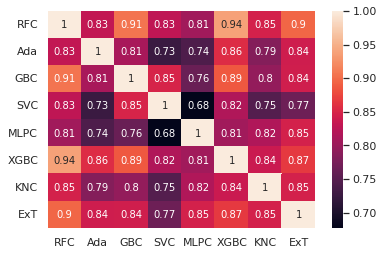

In [167]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_AdaC = pd.Series(AdaBoost_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GradBoost_best.predict(X_test), name="GBC")
test_Survived_MLPC = pd.Series(MLPC_best.predict(X_test), name="MLPC")
test_Survived_XGBC = pd.Series(XGB_best.predict(X_test), name="XGBC")
test_Survived_KNC = pd.Series(KNC_best.predict(X_test), name="KNC")
test_Survived_ExTree = pd.Series(ExtC_best.predict(X_test), name="ExT")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC, test_Survived_MLPC, test_Survived_XGBC, test_Survived_KNC, test_Survived_ExTree],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

By considering the accuracy of each model and the correlation between all the models, I decided to pick 6 models out of 8.

In [175]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('svc', SVMC_best), ('gbc', GradBoost_best), ('adac',AdaBoost_best), ('mlpc',MLPC_best), ('ExtC',ExtC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)
acc_vot = round(votingC.score(X_train, Y_train) * 100, 2)
acc_vot

90.32

In [110]:
Y_pred = random_forest.predict(X_test)
submission = pd.DataFrame({
    "PassengerId": tests["PassengerId"],
    "Survived": Y_pred})
submission.to_csv('submission2.csv', index=False)

This submission got me ranked 3424 out of 14382 with 0.77990 accuracy which I have to say is not bad at all considering the amount of time (3 days) I put in doing this and how simple the engineering is.